# Decison Tree Classifier for Classifying Music Emotions
---
## About the Dataset

For this experiment, our dataset contains 267 music samples that were labelled by 2 music experts. The dataset has a combination of high level and low level features. The high level features are tempo, arousal, and scale, which were all labelled by the music experts. The low level features were extracted from the music samples using the JAudio software.

---
## Libraries

We used the pandas and csv libraries to load the dataset, which is a csv file. Then we used numpy to manipulate the loaded dataset. We used the sci kit learn library for the decision tree algorithm.

In [1]:
import os
import numpy as np
import pandas as pd
import csv
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, norm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel, SelectKBest, VarianceThreshold, chi2, f_classif, mutual_info_classif
from XLB import *
from functools import cmp_to_key
from statistics import mode

import warnings
warnings.filterwarnings('ignore')

Here we load the data from the csv file and preprocess it by removing the header row and the filename column

After the initial preprocessing step, we sperated the music features and the labelled emotion into the x_train and y_train arrays respectively

In [2]:
# extract data from files
x_train, y_train = extract_data("FinalTrainingSet.csv")
x_val, y_val = extract_data("Validation Set.csv")

# scale data values
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)

# feature selection
num_features = 45
feat_sel = VarianceThreshold()
x_train = feat_sel.fit_transform(x_train)
# feat_sel_2 = SelectFromModel(estimator=DecisionTreeClassifier(random_state=481516234))
# feat_sel_2 = SelectFromModel(\
#                 estimator=RandomForestClassifier(n_estimators=50,\
#                                              random_state=481516234))
# feat_sel_2 = SelectFromModel(\
#                 estimator=LogisticRegression(random_state=481516234))
# feat_sel_2 = SelectFromModel(\
#                 estimator=svm.LinearSVC(C=0.25, penalty="l1", dual=False,\
#                                     random_state=481516234))
# WINNER: 47.62% 0.45
feat_sel_2 = SelectKBest(mutual_info_classif,k=num_features)
x_train = feat_sel_2.fit_transform(x_train,y_train)
x_val = feat_sel_2.transform(feat_sel.transform(x_val))
# print("After Variance Threshold Feature Selection:",x_train.shape)

rand_seed = 3454132

oversampler = SMOTE(sampling_strategy="not majority",random_state=rand_seed)
x_smote, y_smote = oversampler.fit_resample(x_train,y_train)
print(x_smote.shape,y_smote.shape)

oversampler = RandomOverSampler(sampling_strategy="not majority",random_state=rand_seed)
x_os, y_os = oversampler.fit_resample(x_train,y_train)
print(x_os.shape,y_os.shape)

(750, 45) (750,)
(750, 45) (750,)


In [3]:
#MOVING FEATURE HEADERS INTO A LIST
import csv

with open("FinalTrainingSet.csv") as f:
    reader = csv.reader(f)
    features = next(reader)

#Deleting everything except features from the dataset
features.remove("Row Labels")
features.remove("Theme")
features.remove("Theme(Numbered)")
print(len(features))
#Retained features after selection
selected_feats = feat_sel_2.get_support(True)

for ind, ft in sorted(enumerate(features), reverse=True): 
    if ind not in selected_feats:
        del features[ind]
  
#Printing modified list 
#print (features) 
#print (len(features))

324


Here we perform different methods to deal with imbalanced datasets. We used the oversampling *Insert link to oversampling if needed* and SMOTE methodology *Insert link to SMOTE if needed*

In [4]:
rand_seed = 3454132

oversampler = SMOTE(sampling_strategy="not majority",random_state=rand_seed)
x_smote, y_smote = oversampler.fit_resample(x_train,y_train)
print(x_smote.shape,y_smote.shape)

oversampler = RandomOverSampler(sampling_strategy="not majority",random_state=rand_seed)
x_os, y_os = oversampler.fit_resample(x_train,y_train)
print(x_os.shape,y_os.shape)

(750, 45) (750,)
(750, 45) (750,)


Here we defined a function that will train the model and perform the hyperparameter search. x_train is the input data, y_train is the labels for the input data, and hp_search is the algorithm for hyperparameter search

This function trains the model, using the previously defined train_model function, and displays the confusion matrix of the model. 

The following cells are the experiments we ran with the default dataset, oversampled version, and SMOTE version using random search as the hyperparameter search algorithm

---
This cell instantiates the decison tree object and the hyperparameter search object.

In [5]:
# Decision Tree
random_search_iterations = 1000
n_splits = 10
rand_seed = 481516234

parameters = {
    'criterion':["gini", "entropy"], 
    'splitter':["best", "random"], 
    'max_depth':range(5, 13), 
    'min_samples_split': uniform(loc=0.00,scale=1.0),
    'min_samples_leaf': uniform(loc=0.0001,scale=0.4999)
}

# train classifier for SMOTE data
dt = tree.DecisionTreeClassifier(random_state=rand_seed)
rscv = RandomizedSearchCV(dt, parameters,cv=n_splits, random_state=rand_seed, n_iter=random_search_iterations,n_jobs=-1)

In [6]:
themes = ["Calm","Cheerful","Bravery","Fearful","Love","Sadness"]

In [7]:
""" 
This functions trains a Classification Based on Associations (CBA) model on a
dataset and tests it on a valdation set.

Parameters:
ruleset : array-like of size (0,) - container for ruleset
X_train : array-like of size (n_train_samples,n_features) 
                                  - training data
y_train : array-like of size (n_train_samples,) 
                                  - ground truth labels of training data
X_val : array-like of size (n_test_samples,n_features) 
                                  - training data
y_val : array-like of size (n_test_samples,) 
                                  - ground truth labels of training data
model_selector : Sklearn estimator object - hyperparameetr search object
feature_names : array-like of size (n_features,) - list of feature names
label_names : array-like of size (n_classes,) - list of class labels
dataset_name : string - name to call the dataset
itr-count : int - tracking for rule number

Returns an array of Rule objects indicating the updated ruleset.
"""
def extract_ruleset(ruleset,X_train,y_train,X_val,y_val,model_selector,
                    feature_names,label_names,dataset_name="Dataset"):
    print_res_6_way(dataset_name,X_train,y_train,model_selector, label_names, verbose = False)
#     disp_tree(rscv.best_estimator_,"FinalTrainingSet.csv")
    test_res_6_way(dataset_name,X_val,y_val,model_selector, label_names)
    ruleset = create_rule_obj(
        model_selector.best_estimator_, feature_names, X_train, label_names, 
        y_train,len(X_train)
    )
    return ruleset

This model is trained using the default 

Best Score: 0.3416
Vanilla Train Accuracy: 34.4140%
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 2. 2. 2. 3. 3. 3. 3. 4. 4. 4. 4. 5. 5. 5. 6. 6. 6.]
Vanilla Validation Accuracy: 19.05%
Vanilla F1-score: 0.06
[0.6882793017456359, 0.8628428927680798, 0.8603491271820449, 0.7531172069825436, 0.9326683291770573, 0.9027431421446384]


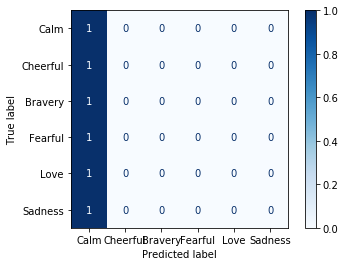

In [8]:
vanilla_rules = []
vanilla_rules = extract_ruleset(
    vanilla_rules,x_train,y_train,x_val,y_val,rscv,features,\
    themes,"Vanilla")

In [43]:
vanilla_rules_sorted = (sorted(vanilla_rules, key = cmp_to_key(comp_func)))
cls, acc = eval_rules(vanilla_rules_sorted, x_train, y_train) 
classifiers = (cls, acc)
accuracy = classifiers[1]
classifiers = remove_unnecessary_rules(vanilla_rules_sorted, accuracy, x_train, y_train)
print_classifier(classifiers, len(x_train))

RULE NUMBER  1 :
 Derivative of Peak Based Spectral Smoothness Overall Standard Deviation <= 0.0300 -> Calm
    confidence: 0.42
    lift: 0.60
    interestingness: 6.91
    error(s):  0
TOTAL MATCHES:  100.0 %



In [45]:
val = []
for i in classifiers[0]:
    val.append(i[0])
pred = predict(val, x_val, y_val, y_train)
print(pred)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [36]:
print("Vanilla ACCURACY:")
compute_accuracy(pred, y_val)
f1 = f1_score(y_val, pred, average = 'weighted')
print("F1 SCORE: ", f1)
print()

Vanilla ACCURACY:
0.19047619047619047
F1 SCORE:  0.06095238095238095



Best Score: 0.4720
Random Oversampling Train Accuracy: 60.1333%
[1. 4. 1. 3. 1. 4. 1. 3. 1. 3. 1. 1. 4. 1. 1. 1. 1. 1. 1. 3. 1.]
[1. 1. 1. 1. 2. 2. 2. 3. 3. 3. 3. 4. 4. 4. 4. 5. 5. 5. 6. 6. 6.]
Random Oversampling Validation Accuracy: 23.81%
Random Oversampling F1-score: 0.19
[0.368, 0.4613333333333333, 0.46, 0.4026666666666667, 0.49866666666666665, 0.4826666666666667]


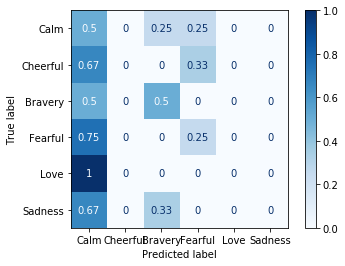

In [13]:
os_rules = []
os_rules = extract_ruleset(
    os_rules,x_os,y_os,x_val,y_val,rscv,features,\
    themes,"Random Oversampling")

In [40]:
os_rules_sorted = sorted(os_rules, key = cmp_to_key(comp_func))
cls, acc = eval_rules(os_rules_sorted, x_os, y_os) 
classifiers = (cls, acc)
accuracy = classifiers[1]
classifiers = remove_unnecessary_rules(os_rules_sorted, accuracy, x_os, y_os)
print_classifier(classifiers, len(x_os))

RULE NUMBER  1 :
 Derivative of Peak Based Spectral Smoothness Overall Standard Deviation > 0.1400 -> Calm
    confidence: 0.11
    lift: 0.29
    interestingness: 2.01
    error(s):  0
TOTAL MATCHES:  100.0 %



In [42]:
val = []
for i in classifiers[0]:
    val.append(i[0])
pred = predict(val, x_val, y_val, y_train)
print(pred)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [33]:
print("OverSampling ACCURACY:")
compute_accuracy(pred, y_val)
f1 = f1_score(y_val, pred, average = 'weighted')
print("F1 SCORE: ", f1)
print()

OverSampling ACCURACY:
0.19047619047619047
F1 SCORE:  0.06095238095238095



Best Score: 0.4667
SMOTE Train Accuracy: 59.6000%
[6. 3. 3. 3. 1. 3. 3. 3. 1. 4. 3. 1. 1. 6. 1. 1. 6. 2. 6. 6. 3.]
[1. 1. 1. 1. 2. 2. 2. 3. 3. 3. 3. 4. 4. 4. 4. 5. 5. 5. 6. 6. 6.]
SMOTE Validation Accuracy: 19.05%
SMOTE F1-score: 0.13
[0.368, 0.4613333333333333, 0.46, 0.4026666666666667, 0.49866666666666665, 0.4826666666666667]


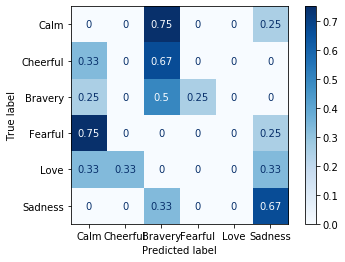

In [26]:
smote_rules = []
smote_rules = extract_ruleset(
    smote_rules,x_smote,y_smote,x_val,y_val,rscv,features,\
    themes,"SMOTE")

In [37]:
smote_rules_sorted = sorted(smote_rules, key = cmp_to_key(comp_func))
cls, acc = eval_rules(smote_rules_sorted, x_smote, y_smote) 
classifiers = (cls, acc)
accuracy = classifiers[1]
classifiers = remove_unnecessary_rules(smote_rules_sorted, accuracy, x_os, y_os)
print_classifier(classifiers, len(x_os))

RULE NUMBER  1 :
 Standard Deviation of Spectral Centroid Overall Average > 0.0400 -> Love
    confidence: 0.13
    lift: 0.26
    interestingness: 4.05
    error(s):  47
RULE NUMBER  2 :
 Derivative of MFCC Overall Average > 0.1800 ^  Derivative of Partial Based Spectral Centroid Overall Standard Deviation <= 0.1200 -> Bravery
    confidence: 0.12
    lift: 0.26
    interestingness: 1.92
    error(s):  0
TOTAL MATCHES:  100.0 %



In [38]:
val = []
for i in classifiers[0]:
    val.append(i[0])
pred = predict(val, x_val, y_val, y_train)
print(pred)

[1.0, 5, 5, 5, 1.0, 5, 1.0, 5, 1.0, 1.0, 1.0, 1.0, 5, 1.0, 5, 1.0, 1.0, 5, 1.0, 1.0, 5]


In [39]:
print("SMOTE ACCURACY:")
compute_accuracy(pred, y_val)
f1 = f1_score(y_val, pred, average = 'weighted')
print("F1 SCORE: ", f1)
print()

SMOTE ACCURACY:
0.09523809523809523
F1 SCORE:  0.047619047619047616

